In [1]:
cd C:\Users\yzhou1\Desktop\infant_hip

C:\Users\yzhou1\Desktop\infant_hip


In [2]:
#%% Import packages
from __future__ import division
import pandas as pd
import numpy as np
from backspinpy import SPIN, backSPIN, feature_selection, CEF_obj, Cef_tools, cef2df
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict
from matplotlib import pyplot as mp
import pickle
import scipy
from scipy.io import mmread
import seaborn as sns
np.random.seed(123)
%matplotlib inline

In [3]:
#%% Load infant human hippocampus snRNA-seq dataset (infant_hip) and annotate the cell prototypes
# Load data
import pickle
file = open(r'C:\Users\yzhou1\Desktop\infant_hip\infant_hip.pkl','rb')
df_infant_hip = pickle.load(file)
cols_annot_all = pickle.load(file)
file.close()

# Preprocess data, mask blood and mitochondrial genes
blood_genes = ['HBG1','HBA1','HBA2','HBE1']
mito_genes = open(r'C:\Users\yzhou1\Desktop\infant_hip\MitoGenes.txt').read().split('"\t"')
del mito_genes[0]
del mito_genes[-1]

df_infant_hip = df_infant_hip.loc[~np.in1d(df_infant_hip.index, blood_genes)&\
                   ~np.in1d(df_infant_hip.index, mito_genes),:]

df_infant_hip = df_infant_hip.loc[:,(df_infant_hip>0).sum(0)>0]
df_infant_hip = df_infant_hip.loc[(df_infant_hip>0).sum(1)>0,:]

# Annotate the prototypic cells
proto = pd.Series({'nonGCneuron':'none', 'astro':'none', 'granuleCell':'none', 'moli':'none', 'opc':'none', 'microglia':'none', 'nonNeuronalCell':'none', 'x':'none',
                   'proto1_microglia':'proto1_microglia', 'proto2_imgc':'proto2_imgc', 'proto3_moli':'proto3_moli', 'proto4_astro':'proto4_astro', 'proto5_opc':'proto5_opc'})

proto_color = {'proto4_astro': (190,10,10), 'proto1_microglia': (190,10,10), 'proto2_imgc':(255,95,105), 'proto5_opc':(50,180,180),'proto3_moli':(50,180,180)}

ct_infant_hip = cols_annot_all[df_infant_hip.columns].loc['Cell_type']
proto_group = proto.loc[ct_infant_hip].values
df_infant_hip = df_infant_hip.loc[:,proto_group != 'none']

In [4]:
#%% Enrich for cell type positive markers
df_fall = df_infant_hip
cell_types = cols_annot_all[df_fall.columns].loc['Cell_type'].values
df_means = df_fall.mean(1) + 1e-5
df_bin = df_fall>0
df_fold = pd.DataFrame()
df_avgpos = pd.DataFrame()

enrichment_order = ['proto4_astro', 'proto1_microglia', 'proto2_imgc', 'proto3_moli', 'proto5_opc']
for ct in enrichment_order:
    df_fold[ct] = df_fall.loc[:,cell_types == ct].mean(1) / df_means
    df_avgpos[ct] = df_bin.loc[:,cell_types == ct].mean(1)

score00 = df_fold
score05 = df_fold * df_avgpos**0.5
score10 = df_fold * df_avgpos

ix00 = np.argsort( score00 , 0)
ix05 = np.argsort( score05 , 0)
ix10 = np.argsort( score10 , 0)

markers = defaultdict(set)

N = 100

for ct in df_fold.columns:
    markers[ct] |= set( df_fold.index[ix00.loc[:,ct][::-1]][:N] )
    markers[ct] |= set( df_fold.index[ix05.loc[:,ct][::-1]][:N] )
    markers[ct] |= set( df_fold.index[ix10.loc[:,ct][::-1]][:N] )

for ct in df_fold.columns:
    for mk in markers[ct]:
        for ct2 in list( set(df_fold.columns) - set([ct])):
            if score10.loc[mk,ct] >= score10.loc[mk,ct2]:
                markers[ct2] -= set([mk])
    for mk in list(markers[ct]):
        if df_avgpos.loc[mk,ct] < 0.15:
            markers[ct] -= set([mk])

list_genes0 = ([list(markers[ct]) for ct in df_fold.columns])
list_genes = list()
for x in list_genes0:
    for a in x:
        list_genes.append(a)

len(list_genes)
df_infant_hip = df_infant_hip.loc[list(set(list_genes)),:]

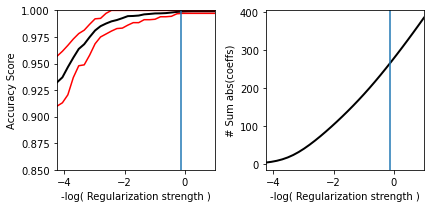

In [5]:
#%% Train model for infant_hip and dup0 ----
# Prepare dataset for training
df_infant_hip_log = np.log2(df_infant_hip + 1)
ct_infant_hip = cols_annot_all[df_infant_hip.columns].loc['Cell_type']
proto_group = proto.loc[ct_infant_hip].values
bool1 = proto_group != 'none'
classes_names, classes_index = np.unique(proto_group[bool1], return_inverse=True, return_counts=False)
train_index = classes_index
df_train_set = df_infant_hip_log.loc[:,bool1].copy()

#Regularization path
normalizer = 0.9*df_train_set.values.max(1)[:,np.newaxis]

LR = LogisticRegressionCV(Cs=np.logspace(-4.25,1,30), refit=True, penalty='l2',
                          solver='newton-cg', fit_intercept=False, multi_class='multinomial',class_weight='balanced',
                          cv=StratifiedShuffleSplit(n_splits=35,test_size=0.15, random_state=123))

LR.fit((df_train_set.values/normalizer).T, train_index)

chos = .75

# Regularization path plot
mp.figure(figsize=(6,3))
mp.subplot(122)
CMA = np.array([abs(LR.coefs_paths_[i]) for i in range(len(set(classes_index)))])
val_ = np.array( [[sum( sum( CMA[:,i,j,:],0) ,0) for i in range(35)] for j in range(30) ] )
mp.plot( np.log10(LR.Cs_),\
     val_.mean(1), c='k' , lw=2 )
mp.xlabel('-log( Regularization strength )')
mp.ylabel('# Sum abs(coeffs)')
mp.xlim(-4.25,1)
mp.axvline( np.log10(chos) )

mp.subplot(121)
mp.plot(np.log10(LR.Cs_), np.mean([LR.scores_[i].mean(0) for i in range(len(set(classes_index)))],0), c='k', lw=2 )
mp.plot(np.log10(LR.Cs_), np.percentile( LR.scores_[1],97.5,0), c='r')
mp.plot(np.log10(LR.Cs_), np.percentile( LR.scores_[1],2.5,0), c='r')
mp.axvline( np.log10(chos) )
mp.ylabel('Accuracy Score')
mp.xlabel('-log( Regularization strength )')
mp.xlim(-4.25,1)
mp.ylim(0.85,1)

mp.tight_layout()
mp.savefig(r'C:\Users\yzhou1\Desktop\infant_hip\outputs\RegPath_infant_hip.pdf')

In [6]:
#%% Final model (Normalized by the max)
LR = LogisticRegression(C=chos, penalty='l2', solver='newton-cg', fit_intercept=False, 
                        multi_class='multinomial',class_weight='balanced',random_state=123)

normalizer = 0.9*df_train_set.values.max(1)[:,np.newaxis]
LR.fit((df_train_set.values / normalizer).T, train_index)

LogisticRegression(C=0.75, class_weight='balanced', fit_intercept=False,
                   multi_class='multinomial', random_state=123,
                   solver='newton-cg')

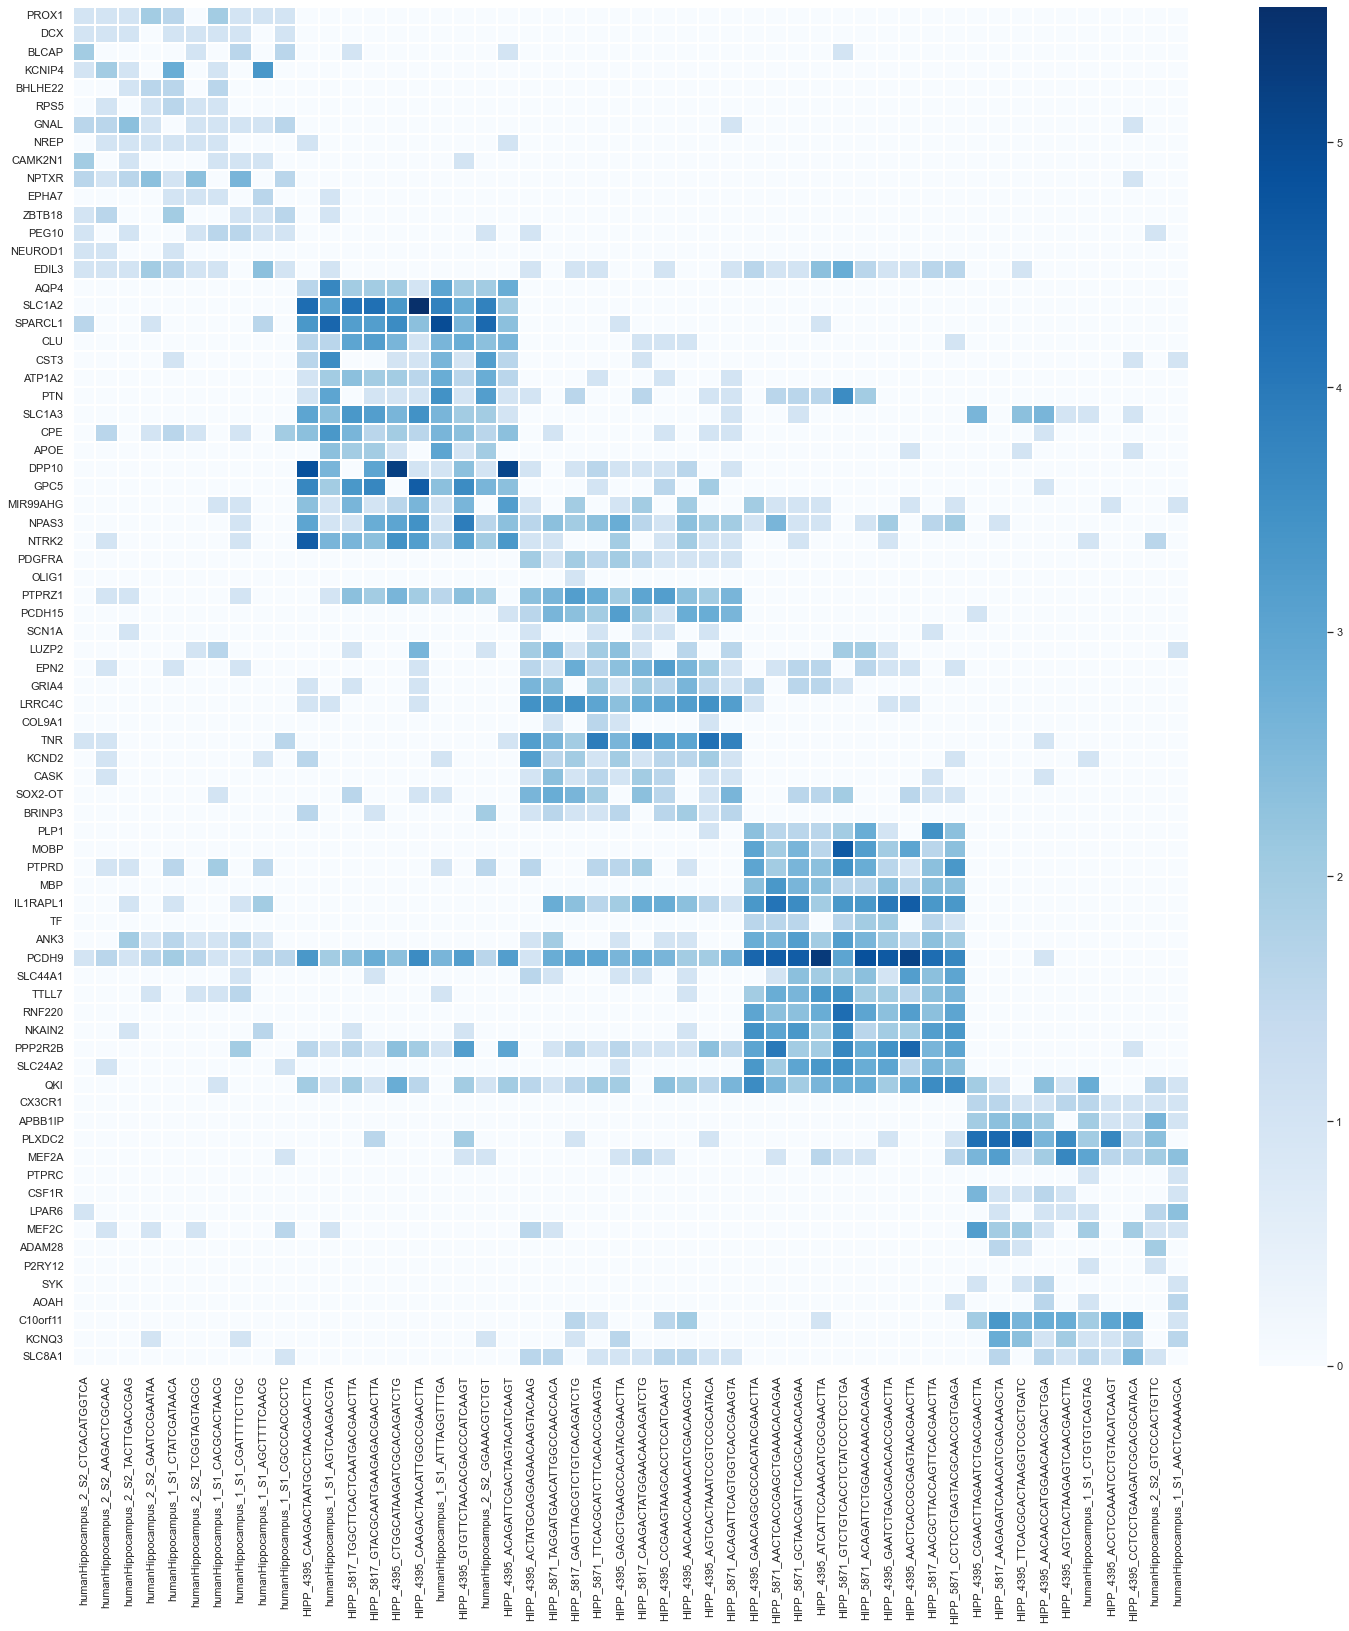

In [7]:
#%% Viualize the top positive weights for each prototype as a heatmap
sel_class = 'proto1_microglia'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_infant_hip_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto1 = names_sorted_coef

sel_class = 'proto2_imgc'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_infant_hip_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto2 = names_sorted_coef

sel_class = 'proto3_moli'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_infant_hip_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto3 = names_sorted_coef

sel_class = 'proto4_astro'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_infant_hip_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto4 = names_sorted_coef

sel_class = 'proto5_opc'
nonzero_coef_bool = LR.coef_[np.where( classes_names == sel_class )[0][0], :] > 0
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ][nonzero_coef_bool]
names_nonzero_coef= df_infant_hip_log.index[nonzero_coef_bool]
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]
names_sorted_coef_proto5 = names_sorted_coef

# Predict cell scores and pick top cells
res = LR.predict_proba((df_train_set.values / normalizer).T)
hist_order = ['proto4_astro', 'proto1_microglia', 'proto2_imgc', 'proto3_moli', 'proto5_opc']
hist_ixes = [list(classes_names).index(i) for i in hist_order]
resdf = pd.DataFrame(res)
resdf.columns = classes_names
resdf.index = df_train_set.columns

# Make a heatmap
top10cells_proto4 = resdf.sort_values('proto4_astro', ascending=False)[:10].index
top10cells_proto1 = resdf.sort_values('proto1_microglia', ascending=False)[:10].index
top10cells_proto2 = resdf.sort_values('proto2_imgc', ascending=False)[:10].index
top10cells_proto5 = resdf.sort_values('proto5_opc', ascending=False)[:10].index
top10cells_proto3 = resdf.sort_values('proto3_moli', ascending=False)[:10].index

top15genes_proto4 = names_sorted_coef_proto4[:15]
top15genes_proto1 = names_sorted_coef_proto1[:15]
top15genes_proto2 = names_sorted_coef_proto2[:15]
top15genes_proto5 = names_sorted_coef_proto5[:15]
top15genes_proto3 = names_sorted_coef_proto3[:15]

topcellsheatmap = df_train_set.loc[top15genes_proto2.tolist() + top15genes_proto4.tolist() + top15genes_proto5.tolist() + top15genes_proto3.tolist() + top15genes_proto1.tolist(),
                                   top10cells_proto2.tolist() + top10cells_proto4.tolist() + top10cells_proto5.tolist() + top10cells_proto3.tolist() + top10cells_proto1.tolist()]

mp.rcParams['savefig.dpi'] = 100
mp.figure(figsize=(25,25))
sns.set(font_scale=1)
sns.heatmap(topcellsheatmap, cmap = 'Blues', linewidths = 0.2, annot=False)
mp.savefig(r'C:\Users\yzhou1\Desktop\infant_hip\outputs\TopWeightHeatmap_infant_hip.pdf')

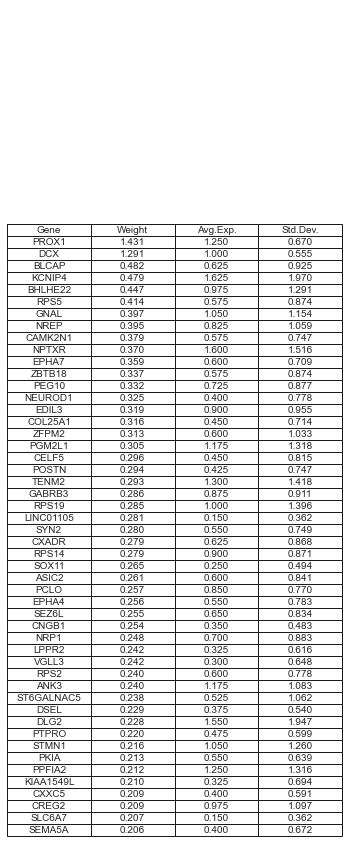

In [8]:
#%% Viualize the top 50 positive weights defining human infant immature neurons
sel_class = 'proto2_imgc'
nonzero_coef_bool = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
values_nonzero_coef = LR.coef_[ np.where( classes_names == sel_class )[0][0],: ]
names_nonzero_coef= df_infant_hip_log.index
ix_nonzero_coef = np.argsort(values_nonzero_coef)[::-1]
values_sorted_coef = values_nonzero_coef[ix_nonzero_coef]
names_sorted_coef = names_nonzero_coef[ix_nonzero_coef]

avg_expr = df_infant_hip.loc[names_sorted_coef, proto_group == sel_class].mean(1)
std_expr = df_infant_hip.loc[names_sorted_coef, proto_group == sel_class].std(1)

# Plot in a matplotlib table
mp.rcParams['savefig.dpi'] = 300
colLabels=("Gene", "Weight", 'Avg.Exp.', 'Std.Dev.')
rows_list = zip(list(names_sorted_coef)[:50],\
                list(map(lambda x: '%.3f' % x, values_sorted_coef[:50])),\
                list(map(lambda x: '%.3f' % x, avg_expr[:50])),\
                list(map(lambda x: '%.3f' % x, std_expr[:50])))
rows_list = list(rows_list)
nrows, ncols = len(rows_list)+1, len(colLabels)
hcell, wcell = 0.02, 0.7
hpad, wpad = 0, 0
fig = mp.figure()
ax = fig.add_subplot(111)
ax.axis('off')
the_table = ax.table(cellText=rows_list, colLabels=colLabels, cellLoc='center')